# **Feed Forward Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0001
- Layers: [256, 128, 64]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [45]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/NotAnnotated/Regular/AveragePooled/split_features_3s_all_1D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [46]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/FFNN/'

In [47]:
train_data = data['train'].copy()
val_data = data['val'].copy()

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [48]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [49]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [50]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **Feed Forward Model**

In [51]:
def build_model(input_features,
                hidden_layers=[256, 128, 64],
                learning_rate=0.0001,
                output_units=20,
                dropout_rate=0.3):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [52]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_1D.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [53]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [54]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [55]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['cqt'], train_features['melspectrogram']), axis=1)
training_features.shape

(13725, 244)

In [56]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['cqt'], val_features['melspectrogram']), axis=1)
validation_features.shape

(4231, 244)

In [57]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1578 - loss: 2.8829 - val_accuracy: 0.2184 - val_loss: 2.6455
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3376 - loss: 2.2005 - val_accuracy: 0.2706 - val_loss: 2.4726
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4133 - loss: 1.9767 - val_accuracy: 0.3311 - val_loss: 2.3605
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4708 - loss: 1.7898 - val_accuracy: 0.3333 - val_loss: 2.3279
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5019 - loss: 1.6895 - val_accuracy: 0.3479 - val_loss: 2.2905
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5331 - loss: 1.5607 - val_accuracy: 0.3578 - val_loss: 2.2820
Epoch 7/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5610 - loss: 1.4750 - val_accuracy: 0.3529 - val_loss: 2.2607
Epoch 8/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5870 - loss: 1.3876 - val_accu

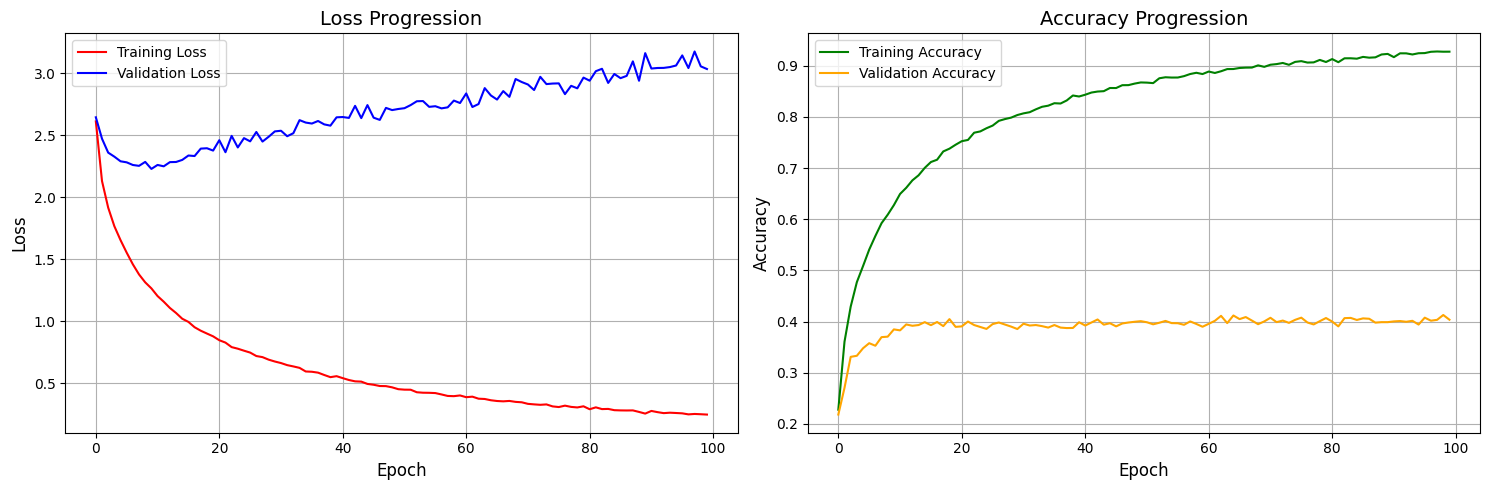

In [58]:
visualize(history, 'all_features')

In [59]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9854 - loss: 0.0632
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4103 - loss: 3.0100


In [60]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.39      0.48      0.43       260
           1       0.38      0.62      0.47       424
           2       0.42      0.35      0.38       200
           3       0.47      0.75      0.58       318
           4       0.11      0.16      0.13        73
           5       0.11      0.09      0.10        99
           6       0.05      0.05      0.05        86
           7       0.61      0.43      0.50       224
           8       0.15      0.64      0.24        50
           9       0.39      0.42      0.41        71
          10       0.43      0.33      0.37       146
          11       0.19      0.03      0.05       549
          12       0.53      0.47      0.50       415
          13       0.40      0.37      0.38       160
          14       0.08      0.20      0.12        46
          15       0.36      0.47      0.41       255
          16       0.84      0.93      0.88   

### Mel Spectrogram and Chroma

In [61]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma']), axis=1)
training_features.shape

(13725, 140)

In [62]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma']), axis=1)
validation_features.shape

(4231, 140)

In [63]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1263 - loss: 2.9173 - val_accuracy: 0.2070 - val_loss: 2.6375
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2981 - loss: 2.3229 - val_accuracy: 0.2678 - val_loss: 2.5439
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3559 - loss: 2.1064 - val_accuracy: 0.2798 - val_loss: 2.4938
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3943 - loss: 1.9806 - val_accuracy: 0.3037 - val_loss: 2.4646
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4272 - loss: 1.8764 - val_accuracy: 0.3110 - val_loss: 2.4396
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4676 - loss: 1.7715 - val_accuracy: 0.3158 - val_loss: 2.4304
Epoch 7/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4734 - loss: 1.7151 - val_accuracy: 0.3207 - val_loss: 2.4052
Epoch 8/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5074 - loss: 1.6350 - val_accu

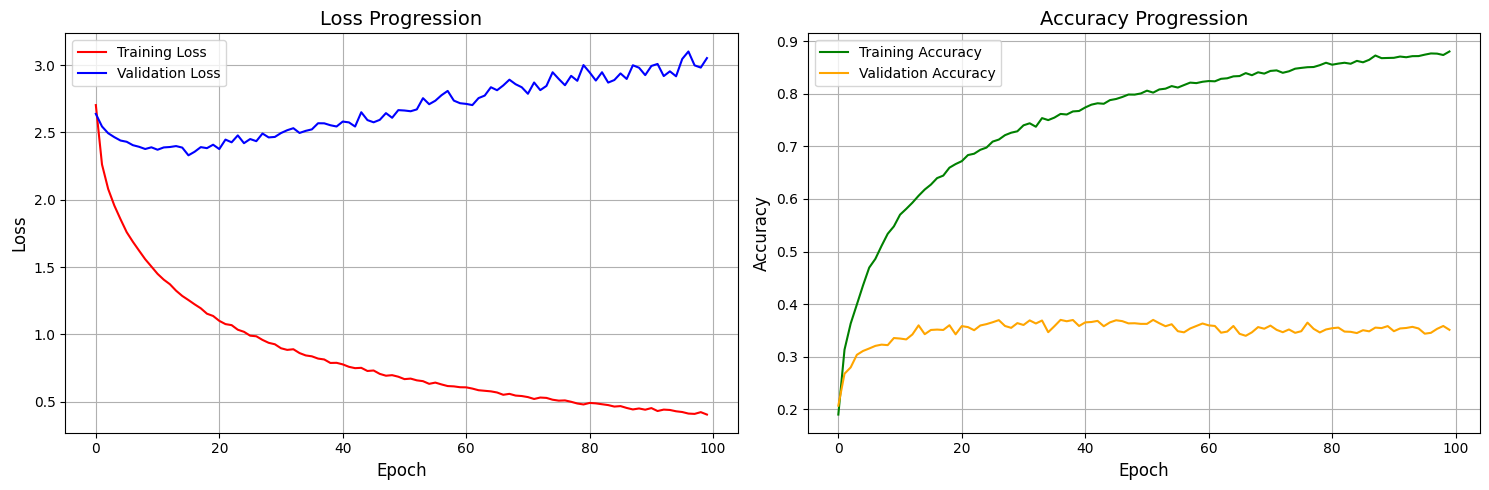

In [64]:
visualize(history, 'melspectrogram_chroma')

In [65]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9603 - loss: 0.1595
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3530 - loss: 3.0331


In [66]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.40      0.46      0.43       260
           1       0.48      0.68      0.56       424
           2       0.47      0.34      0.39       200
           3       0.45      0.68      0.54       318
           4       0.18      0.29      0.22        73
           5       0.14      0.12      0.13        99
           6       0.06      0.02      0.03        86
           7       0.58      0.53      0.55       224
           8       0.15      0.54      0.23        50
           9       0.29      0.42      0.34        71
          10       0.27      0.31      0.29       146
          11       0.31      0.03      0.05       549
          12       0.31      0.27      0.28       415
          13       0.49      0.35      0.41       160
          14       0.04      0.13      0.06        46
          15       0.23      0.40      0.29       255
          16       0.46      0.43      0.44   

### With Mel Spectrogram, MFCCs and Chroma

In [67]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)
training_features.shape

(13725, 160)

In [68]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)
validation_features.shape

(4231, 160)

In [69]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1124 - loss: 2.9710 - val_accuracy: 0.1867 - val_loss: 2.6665
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2917 - loss: 2.3167 - val_accuracy: 0.2567 - val_loss: 2.5009
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3698 - loss: 2.0735 - val_accuracy: 0.2768 - val_loss: 2.4269
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4354 - loss: 1.8766 - val_accuracy: 0.2841 - val_loss: 2.4011
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4648 - loss: 1.7716 - val_accuracy: 0.2928 - val_loss: 2.3666
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5004 - loss: 1.6507 - val_accuracy: 0.3174 - val_loss: 2.3191
Epoch 7/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5328 - loss: 1.5729 - val_accuracy: 0.3063 - val_loss: 2.3066
Epoch 8/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5546 - loss: 1.5002 - val_accu

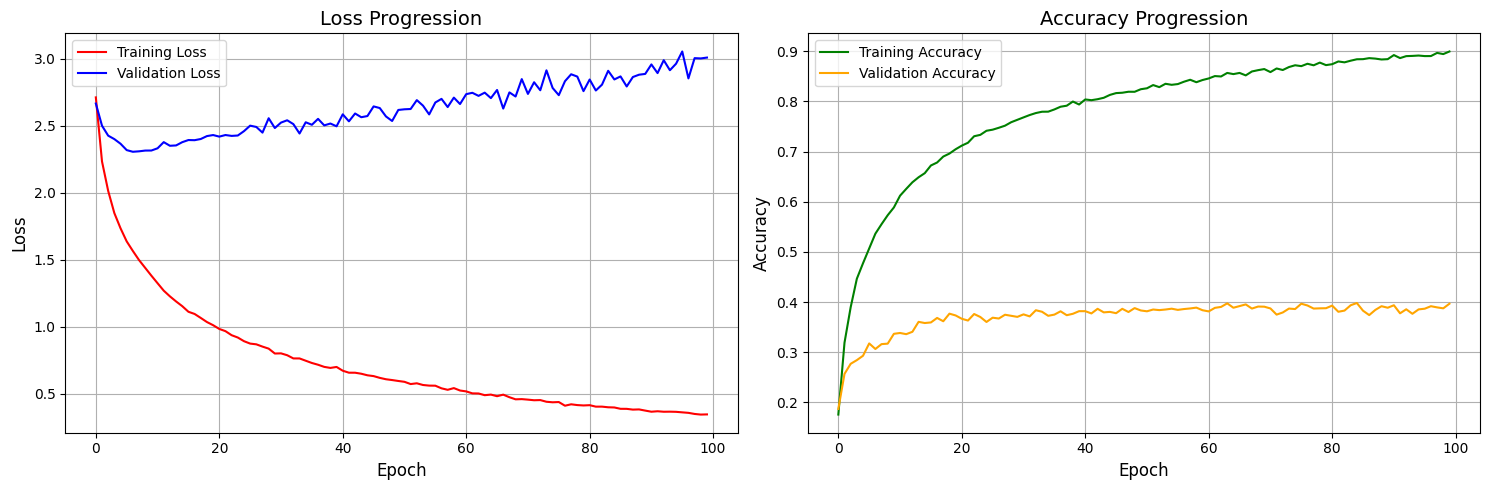

In [70]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [71]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9750 - loss: 0.1097
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4034 - loss: 2.9542


In [72]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.35      0.48      0.40       260
           1       0.40      0.72      0.52       424
           2       0.51      0.34      0.41       200
           3       0.48      0.74      0.58       318
           4       0.33      0.29      0.31        73
           5       0.15      0.08      0.10        99
           6       0.00      0.00      0.00        86
           7       0.51      0.49      0.50       224
           8       0.13      0.50      0.20        50
           9       0.32      0.44      0.37        71
          10       0.38      0.35      0.37       146
          11       0.28      0.03      0.05       549
          12       0.50      0.35      0.41       415
          13       0.38      0.46      0.42       160
          14       0.10      0.24      0.14        46
          15       0.30      0.42      0.35       255
          16       0.59      0.77      0.67   

### With Mel Spectrogram and MFCCs

In [73]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc']), axis=1)
training_features.shape

(13725, 148)

In [74]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc']), axis=1)
validation_features.shape

(4231, 148)

In [75]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1385 - loss: 2.9080 - val_accuracy: 0.2468 - val_loss: 2.6683
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3231 - loss: 2.2473 - val_accuracy: 0.2966 - val_loss: 2.5275
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3981 - loss: 2.0180 - val_accuracy: 0.3129 - val_loss: 2.4926
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4309 - loss: 1.8870 - val_accuracy: 0.3056 - val_loss: 2.4329
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4752 - loss: 1.7569 - val_accuracy: 0.3153 - val_loss: 2.4240
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5040 - loss: 1.6509 - val_accuracy: 0.3214 - val_loss: 2.3992
Epoch 7/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5266 - loss: 1.5901 - val_accuracy: 0.3200 - val_loss: 2.3934
Epoch 8/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5469 - loss: 1.5021 - val_accu

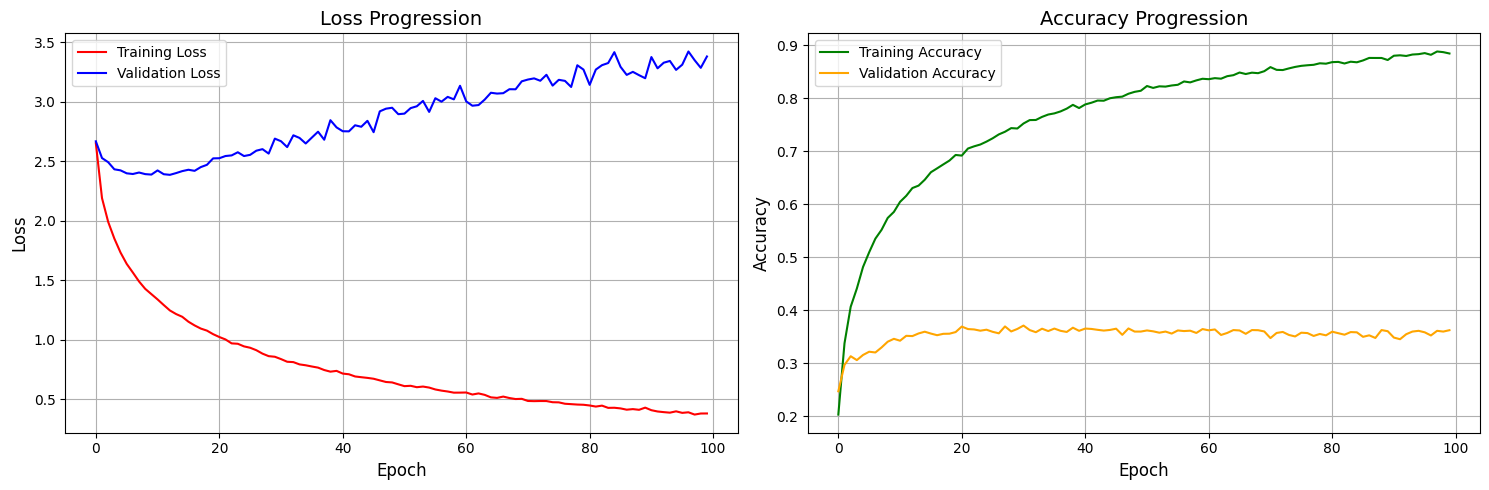

In [76]:
visualize(history, 'mfcc_melspectrogram')

In [77]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9689 - loss: 0.1296
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3645 - loss: 3.3450


In [78]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.42      0.48      0.45       260
           1       0.35      0.69      0.47       424
           2       0.57      0.41      0.48       200
           3       0.44      0.68      0.53       318
           4       0.12      0.10      0.11        73
           5       0.02      0.01      0.01        99
           6       0.11      0.03      0.05        86
           7       0.56      0.56      0.56       224
           8       0.13      0.52      0.20        50
           9       0.35      0.44      0.39        71
          10       0.46      0.38      0.42       146
          11       0.20      0.03      0.05       549
          12       0.46      0.39      0.42       415
          13       0.41      0.46      0.43       160
          14       0.11      0.24      0.15        46
          15       0.24      0.38      0.30       255
          16       0.38      0.23      0.29   

### With Mel Spectrogram

In [79]:
training_features = train_features['melspectrogram']
training_features.shape

(13725, 128)

In [80]:
validation_features = val_features['melspectrogram']
validation_features.shape

(4231, 128)

In [81]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
)

Epoch 1/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1348 - loss: 2.9203 - val_accuracy: 0.2023 - val_loss: 2.6785
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2885 - loss: 2.3249 - val_accuracy: 0.2564 - val_loss: 2.5693
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3481 - loss: 2.1365 - val_accuracy: 0.2808 - val_loss: 2.5168
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3911 - loss: 1.9745 - val_accuracy: 0.2997 - val_loss: 2.4574
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4271 - loss: 1.8760 - val_accuracy: 0.3259 - val_loss: 2.4382
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4464 - loss: 1.8024 - val_accuracy: 0.3058 - val_loss: 2.4357
Epoch 7/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4735 - loss: 1.7383 - val_accuracy: 0.3091 - val_loss: 2.4029
Epoch 8/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4933 - loss: 1.6825 - val_accu

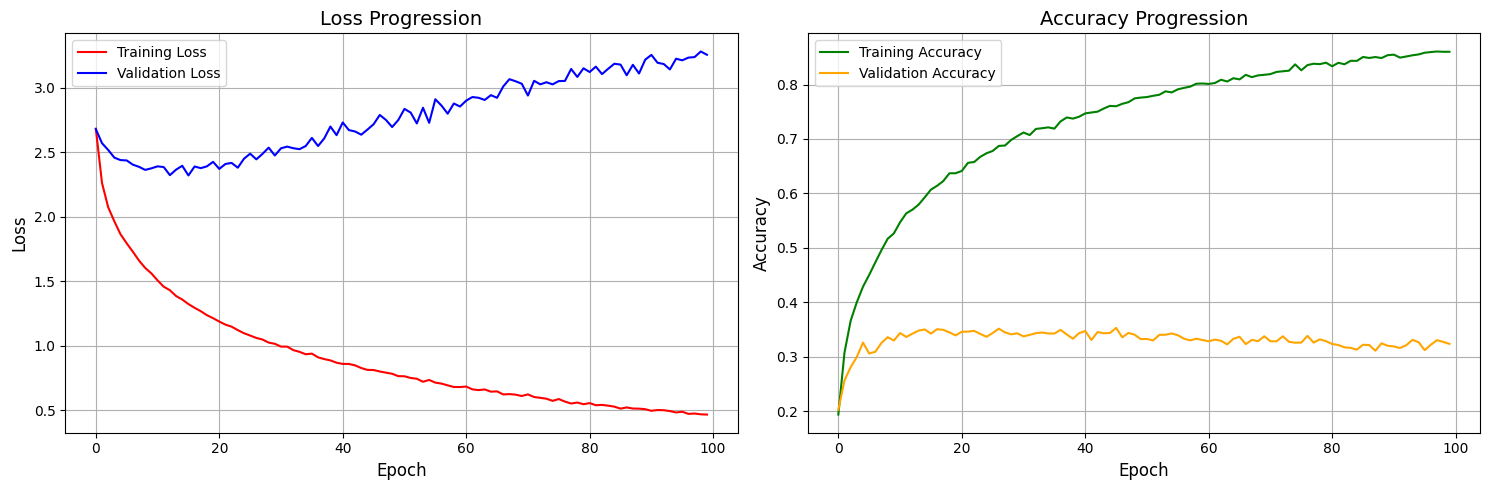

In [82]:
visualize(history, 'melspectrogram')

In [83]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9501 - loss: 0.1947
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3231 - loss: 3.2436


In [84]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.36      0.53      0.43       260
           1       0.44      0.64      0.52       424
           2       0.42      0.33      0.37       200
           3       0.47      0.66      0.55       318
           4       0.12      0.15      0.14        73
           5       0.07      0.04      0.05        99
           6       0.00      0.00      0.00        86
           7       0.61      0.49      0.54       224
           8       0.14      0.56      0.23        50
           9       0.34      0.42      0.38        71
          10       0.25      0.25      0.25       146
          11       0.05      0.01      0.02       549
          12       0.23      0.24      0.23       415
          13       0.39      0.46      0.42       160
          14       0.07      0.22      0.10        46
          15       0.22      0.36      0.27       255
          16       0.33      0.27      0.30   

## Review all the results

In [85]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.986,0.404
4,melspectrogram,0.950,0.324
1,melspectrogram_chroma,0.959,0.351
2,melspectrogram_chroma_mfcc,0.974,0.397
3,mfcc_melspectrogram,0.968,0.362


In [86]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.381      0.840
4              melspectrogram     0.299      0.801
1       melspectrogram_chroma     0.330      0.816
2  melspectrogram_chroma_mfcc     0.366      0.838
3         mfcc_melspectrogram     0.335      0.803
